#　Evaluate Performance
* Retrival Performance (hit rate, mrr)
* Rag Performance (llm as judge)

# Retrival Performance
## Description

In this project, we are working with **53 different types of supplements**. To enhance our retrieval process for these supplements, we employed **Google Gemini Pro** as our language model for generating augmented questions. Google Gemini Pro was chosen over alternatives like Ollama-Phi3 due to its **superior speed and efficiency**.

For each supplement, we generated **5 distinct questions** based on the provided supplement information, resulting in a total of **265 questions**. These questions were then stored in a database.

To evaluate the effectiveness of our retrieval system, we use **Elasticsearch** to search for these questions and assess if the generated questions can be accurately matched with the original queries. The performance of the retrieval system is measured using two key metrics:

- **Hit Rate**: Measures the proportion of queries for which relevant results are retrieved.
- **Mean Reciprocal Rank (MRR)**: Evaluates the average rank position of the first relevant result for a set of queries.

This approach helps in validating the retrieval accuracy and effectiveness of our system in handling queries related to various supplements.



In [177]:
import json
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from elasticsearch import Elasticsearch
import google.generativeai as genai
from typing import List, Dict
import os
from openai import OpenAI
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [22]:
from dotenv import load_dotenv

In [23]:
load_dotenv()

True

### Read supplemnent info file

In [132]:
with open('supplement.json', 'rt') as f:
    doc_raw = json.load(f)

### Import model:
1. embedding model
2. llm (google gemini-pro)

In [133]:
embed_model = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(embed_model)
combine = "purpose: {purpose}, who should not user: {who_should_not_use}, common side effect: {common_side_effects}"

for i in tqdm(doc_raw):
    i['combine'] = combine.format(**i)
    i['combinev'] = model.encode(i['combine'])
    i['purposev'] = model.encode(i['purpose'])
    i['who_should_not_usev'] = model.encode(i['who_should_not_use'])
    i['common_side_effectsv'] = model.encode(i['common_side_effects'])

c:\Users\HSUPC\llm-project\.venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/53 [00:00<?, ?it/s]

In [18]:
modelg = genai.GenerativeModel()

In [29]:
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

### Set Elasticsearch:
1. mapping and knowledge base are in another file.
2. define elasticsearch query

In [4]:
es_client = Elasticsearch('http://localhost:9200')

In [9]:
es_index = 'supplement'

In [35]:
client = OpenAI(
    base_url = 'http://localhost:11434/v1/',
    api_key = 'ollama',
)

In [135]:
es_setting = {
    'settings':{
        'number_of_shards':1,
        'number_of_replicas':0
    },
    'mappings':{
        'properties':{
            'name':{'type':'keyword'},
            'purpose':{'type':'text'},
            'who_should_not_use':{'type':'text'},
            'common_side_effects':{'type':'text'},
            'recommended_dosage':{'type':'text'},
            'source':{'type':'keyword'},
            'vegan_friendly':{'type':'boolean'},
            'combine':{'type':'text'},
            'purposev':{'type':'dense_vector',
                        'dims':384,
                         'index': True,
                         'similarity': 'cosine'
                        },
            'who_should_not_usev':{'type':'dense_vector',
                        'dims':384,
                         'index': True,
                         'similarity': 'cosine'
                        },
            'common_side_effectsv':{'type':'dense_vector',
                        'dims':384,
                         'index': True,
                         'similarity': 'cosine'
                        },
            'combinev':{'type':'dense_vector',
                        'dims':384,
                         'index': True,
                         'similarity': 'cosine'
                        }
            
        }
    }
}

In [136]:
es_client.indices.delete(index= es_index, ignore_unavailable= True)
es_client.indices.create(index = es_index, body= es_setting)
for i in tqdm(doc_raw):
    es_client.index(index= es_index, document= i)

  0%|          | 0/53 [00:00<?, ?it/s]

In [188]:
def hybrid_search(query: str, field: str, vegan: bool = False, boost: float = 0.5) -> List:

    query_v = model.encode(query)
    vector_field = field+'v'
    
    knn_search_hybird = {
        'field': vector_field,
        'query_vector' :query_v,
        'k':5,
        'num_candidates': 10000,
        'boost': boost,
    }

    keyword_search_hybrid = {
        'bool':{
            'must':{
                'multi_match':{
                    'query': query,
                    'fields': field,
                    'type':'best_fields',
                    'boost': 1-boost
                }
            }
        }
    }

    if vegan:
        knn_search_hybird['filter'] = {
            'term':{
                'vegan_friendly': True
            }
        }

        keyword_search_hybrid['bool']['filter'] ={
            'term':{
                'vegan_friendly': True
            }
        }
    

    search_query = {
        'knn': knn_search_hybird,
        'query':keyword_search_hybrid,
        'size':5,
        '_source':['name', 'purpose', 'who_should_not_use', 'common_side_effects', 'vegan_friendly']       
    }

    response = es_client.search(index = es_index, body= search_query)

    result = []
    for hits in response['hits']['hits']:
        result.append(hits['_source'])
    return result
    

### Generate augmented questions by gemini-pro:
1. build prompt: prompt is modified by chatgpt several times
2. Call gemini-pro

In [65]:
prompt_genq = '''
You are tasked with generating five specific questions that a user might ask a health supplement expert. The user does not have access to specific information about the supplement but is seeking advice on related health issues.

Instructions:

Format: Provide the questions in JSON format.
Detail: Each question should be complete and detailed, addressing common health concerns or symptoms.
Focus Areas:
At least three of the five questions should focus on symptoms, allergies, or general health concerns, such as “I am experiencing…” or “I would like to improve…”. These questions should not mention any specific supplement but should seek advice based on general health issues.
Two of the questions can inquire about the supplement's specific attributes, such as its benefits or suitability for certain conditions.
Clarity: Use varied wording to ensure clarity and avoid repetition. Each question should be phrased in a way that allows the health supplement expert to provide relevant recommendations based on general knowledge about health supplements.
Context: The answers should be based on general knowledge and should be applicable to a variety of health supplements, without reference to the specific supplement's name or attributes.

Supplement info:
name: {name}
purpose: {purpose}
who_should_not_use: {who_should_not_use}
common_side_effects: {common_side_effects}
vegan_friendly: {vegan_friendly}

Provide the output in parsable JSON without using code blocks:
{{"questions": ["question1", "question2", ..., "question5"]}}
Check again if the format is as above.
'''.strip()

In [70]:
print(prompt_genq.format(**doc_raw[5]))

You are tasked with generating five specific questions that a user might ask a health supplement expert. The user does not have access to specific information about the supplement but is seeking advice on related health issues.

Instructions:

Format: Provide the questions in JSON format.
Detail: Each question should be complete and detailed, addressing common health concerns or symptoms.
Focus Areas:
At least three of the five questions should focus on symptoms, allergies, or general health concerns, such as “I am experiencing…” or “I would like to improve…”. These questions should not mention any specific supplement but should seek advice based on general health issues.
Two of the questions can inquire about the supplement's specific attributes, such as its benefits or suitability for certain conditions.
Clarity: Use varied wording to ensure clarity and avoid repetition. Each question should be phrased in a way that allows the health supplement expert to provide relevant recommendati

In [253]:
resg = modelg.generate_content(prompt_genq.format(**doc_raw[5]))

In [254]:
print(resg.text)

{"questions": ["I am experiencing discomfort and bloating after starting a new health supplement. What could be the cause, and what can I do to alleviate these symptoms?", "I would like to improve the health of my bones and joints. Are there any health supplements that could support this goal?", "I have an allergy to dairy products. Are there any vegan-friendly health supplements that can provide me with the essential nutrients I am missing?", "What are the potential benefits of incorporating a calcium supplement into my daily routine, and are there any individuals who should avoid calcium supplementation?", "I am looking for a health supplement that can help reduce the frequency and severity of my muscle cramps. Do you have any recommendations?"]}


In [73]:
def gen_prompt(doc):
    prompt = prompt_genq.format(**doc)
    json_res = modelg.generate_content(prompt)

    return json_res.text

In [74]:
result = {}

In [77]:
for doc in tqdm(doc_raw):
    try:
        doc_name = doc['name']
        if doc_name in result:
            continue
        question = gen_prompt(doc)
        result[doc_name] = question
    except Exception as e:
        if '429' in str(e):
            print(e)
            time.sleep(10)
        else:
            raise

  0%|          | 0/53 [00:00<?, ?it/s]

In [80]:
with open('supplement_entended_question.json', 'w') as f:
    json.dump(result, f)

In [83]:
len(result)

53

In [99]:
questions_doc = []

for name, q in result.items():
    for qj in q['questions']:
        questions_doc.append((name, qj))
        

In [107]:
df = pd.DataFrame(questions_doc, columns=['name', 'question'])

In [109]:
df.head(10)

,name,question
0,Vitamin C,I have been experiencing persistent fatigue an...
1,Vitamin C,I suffer from kidney stones and am cautious ab...
2,Vitamin C,I am looking to strengthen my immune system an...
3,Vitamin C,"As someone who follows a vegan diet, I want to..."
4,Vitamin C,"I often experience digestive issues, including..."
5,Vitamin D,I have been experiencing frequent fatigue and ...
6,Vitamin D,I am dealing with high calcium levels and need...
7,Vitamin D,I want to strengthen my immune system and impr...
8,Vitamin D,"As someone who follows a vegan diet, I need to..."
9,Vitamin D,I have noticed that some supplements I take ca...


In [110]:
ground_truth = df.to_dict(orient='records') 
ground_truth[4:9]

[{'name': 'Vitamin C',
  'question': 'I often experience digestive issues, including upset stomach and headaches. Can you suggest any supplements that are known for being gentle on the stomach and have minimal side effects?'},
 {'name': 'Vitamin D',
  'question': 'I have been experiencing frequent fatigue and muscle aches. What types of supplements are typically recommended to help with these symptoms and support overall bone health?'},
 {'name': 'Vitamin D',
  'question': 'I am dealing with high calcium levels and need to be cautious about my supplement intake. Are there any general guidelines or alternatives for someone in my situation?'},
 {'name': 'Vitamin D',
  'question': 'I want to strengthen my immune system and improve my bone health. What are some common supplements known to support these areas effectively?'},
 {'name': 'Vitamin D',
  'question': 'As someone who follows a vegan diet, I need to ensure that any supplements I take align with my dietary choices. What should I loo

In [112]:
df.describe()

,name,question
count,265,265
unique,53,265
top,Vitamin C,I'm considering Glycyrrhizin for its anti-infl...
freq,5,1


### Evaluate searching result:
1. hit rate
2. MRR

In [219]:
def hit(relevance_total):
    cnt = 0
    for i in relevance_total:
        if True in i:
            cnt +=1
    return cnt/len(relevance_total)

def mrr(relevance_total):
    score = 0.0

    for i in relevance_total:
        for j in range(len(i)):
            if i[j] is True:
                score += 1/(j+1)
    return score/len(relevance_total)
            

In [201]:
def eval(ground_truth, search_method, field, vegan = False, boost = 0.5):
    '''
    result: from the original file (doc) find the 5 most relevant context given the question from ground truth.
    relevance: see if the id is the same as the id which we used to create those questions.
    '''
    re_total = []
    for q in tqdm(ground_truth):
        sup_name = q['name']
        result = search_method(query=q['question'], field = field, vegan = vegan, boost = boost)
        relevance = [d['name'] == sup_name for d in result]
        re_total.append(relevance)

    return {'hit_rate': hit(re_total), 'mrr': mrr(re_total)}

In [163]:
# question llm model: gemini-pro, elaseticsearch field: purpose
gemini_purpose = eval(ground_truth, hybrid_search, 'purpose')

  0%|          | 0/265 [00:00<?, ?it/s]

In [164]:
gemini_purpose

{'hit_rate': 0.35094339622641507, 'mrr': 0.22427672955974853}

In [165]:
# question llm model: gemini-pro, elaseticsearch field: combine
gemini_combine = eval(ground_truth, hybrid_search, 'combine')

  0%|          | 0/265 [00:00<?, ?it/s]

In [166]:
gemini_combine

{'hit_rate': 0.4641509433962264, 'mrr': 0.3124528301886793}

### Generate augmented questions from chat gpt
I think part of the reason that cause low hit rate and mrr is the question gimini pro generated. Since I only have 53 kinds of supplement, I asked chat gpt to generate these question for me (and I don't have gpt api, I just asked in website...)

In [146]:
with open('supplement_extended_question_gpt.json','rt') as f_in:
    gpt = json.load(f_in)

In [147]:
questions_gpt = []

for name, q in gpt.items():
    for qj in q['questions']:
        questions_gpt.append((name, qj))

In [150]:
df1 = pd.DataFrame(questions_gpt, columns=['name', 'question'])
df1.head()

,name,question
0,Vitamin C,I am experiencing gastrointestinal upset and h...
1,Vitamin C,I have a history of kidney stones. Are there a...
2,Vitamin C,I want to boost my immune system and improve m...
3,Vitamin C,When choosing supplements for immune support a...
4,Vitamin C,"For someone with kidney stones, what supplemen..."


In [151]:
ground_truth1 = df1.to_dict(orient='records') 
ground_truth1[4:9]

[{'name': 'Vitamin C',
  'question': 'For someone with kidney stones, what supplements might pose health risks, and how can these risks be effectively managed?'},
 {'name': 'Vitamin D',
  'question': 'I often feel nauseous and have headaches. Could these symptoms be related to a supplement, and what are some tips to reduce these side effects?'},
 {'name': 'Vitamin D',
  'question': 'I have a history of high calcium levels. What supplements should be avoided in this situation?'},
 {'name': 'Vitamin D',
  'question': 'I want to improve bone health and enhance my immune system. What are common supplements or lifestyle changes that can achieve these goals?'},
 {'name': 'Vitamin D',
  'question': 'When selecting supplements for bone health and immune support, what specific benefits and effects should be noted?'}]

In [172]:
# question llm model: chat gpt, elaseticsearch field: purpose
gpt_purpose = eval(ground_truth1, hybrid_search, 'purpose')

  0%|          | 0/265 [00:00<?, ?it/s]

In [173]:
gpt_purpose

{'hit_rate': 0.7924528301886793, 'mrr': 0.7183018867924527}

In [174]:
# question llm model: chat gpt, elaseticsearch field: combine
gpt_combine = eval(ground_truth1, hybrid_search, 'combine')

  0%|          | 0/265 [00:00<?, ?it/s]

In [175]:
gpt_combine

{'hit_rate': 0.969811320754717, 'mrr': 0.8149685534591194}

### Result

1. The search performance for ChatGPT-augmented questions is better than that of questions generated by Gemini-Pro.
2. Combining fields (purpose, who_should_not_use, common_side_effect) performs better than using only the purpose field.


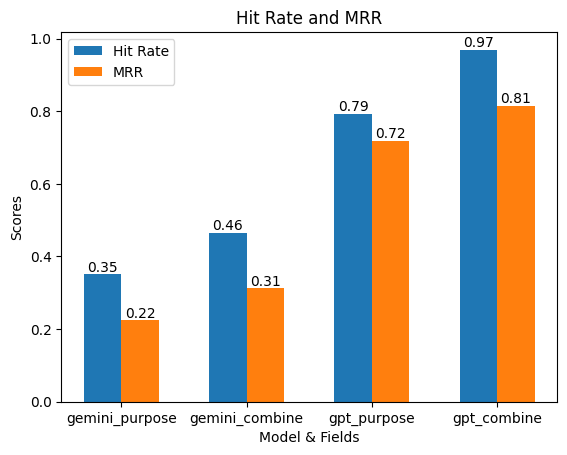

In [187]:
variables = ['gemini_purpose', 'gemini_combine', 'gpt_purpose', 'gpt_combine']
hit_rates = [gemini_purpose['hit_rate'], gemini_combine['hit_rate'], gpt_purpose['hit_rate'], gpt_combine['hit_rate'], ]
mrrs = [gemini_purpose['mrr'], gemini_combine['mrr'], gpt_purpose['mrr'], gpt_combine['mrr'], ]

bar_width = 0.3

x = np.arange(len(variables))
fig, ax = plt.subplots()

bars1 = ax.bar(x - bar_width/2, hit_rates, bar_width, label='Hit Rate')

bars2 = ax.bar(x + bar_width/2, mrrs, bar_width, label='MRR')

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

ax.set_xlabel('Model & Fields')
ax.set_ylabel('Scores')
ax.set_title('Hit Rate and MRR')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.legend()

plt.show()

## Hybrid search - change boost

Boost Rate Calculation and Selection

* KNN Search Boost Rate = **boost**
* Keyword Search Boost Rate = **1 − boost**

Based on the comparison of boost rates ranging from 0.1 to 0.9, I have selected 0.7 as the optimal boost rate here.
Improvement:
* boost = 0.5 -> {'hit_rate': 0.969811320754717, 'mrr': 0.8149685534591194}
* boost = 0.7 -> {'hit_rate': 0.9660377358490566, 'mrr': 0.8274213836477988}




In [221]:
hit_rate_list = []
mrr_rate_list = []

for i in tqdm(np.arange(0.1,1.0, 0.1)):
    eval_rate = eval(ground_truth1, hybrid_search, 'combine', boost = i)
    hit_rate_list.append(eval_rate['hit_rate'])
    mrr_rate_list.append(eval_rate['mrr'])


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

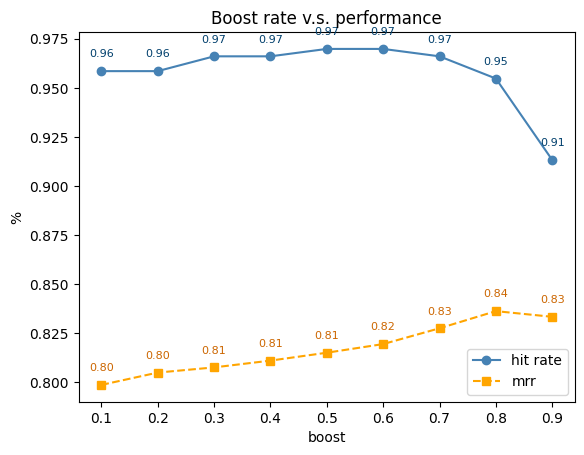

In [237]:
x = np.linspace(0.1, 0.9, 9)
fig, ax = plt.subplots()

ax.plot(x, hit_rate_list, marker='o', linestyle='-', color='#4682B4', label='hit rate')
ax.plot(x, mrr_rate_list, marker='s', linestyle='--', color='orange', label='mrr')

ax.set_xlabel('boost')
ax.set_ylabel('%')
ax.set_title('Boost rate v.s. performance')

for i in range(len(x)):
    ax.annotate(f'{hit_rate_list[i]:.2f}', (x[i], hit_rate_list[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='#003f6c')
    ax.annotate(f'{mrr_rate_list[i]:.2f}', (x[i], mrr_rate_list[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='#cc6600')

ax.set_xticks(np.arange(0.1, 1.0, 0.1))
ax.set_xticklabels([f'{i:.1f}' for i in np.arange(0.1, 1.0, 0.1)])

ax.legend()

plt.show()

# Rag Performance
1. Set up rag performance prompt template
2. call gimini pro

In [264]:
prompt2_template = """
You are an expert evaluator for a RAG system. 
Your task is to analyze the relevance of the generated answer to the given question. 
Based on this relevance, classify the answer as one of the following: "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}

Check again to make sure format is correct.
""".strip()

In [265]:
result_gemini = pd.read_csv('result_gemini.csv')
result_gemini = result_gemini.to_dict(orient='records')

In [266]:
result_gemini[0]

{'answer_llm': "**Possible Supplement-Related Issues:**\n\n* Green Tea Extract: Can cause stomach upset and headaches\n* L-Glutamine: Can cause gastrointestinal issues and headaches\n* Acai Berry Extract: Can cause digestive issues and headaches\n* Quercetin: Can cause headaches and digestive issues\n\n**Dietary Recommendations to Reduce Symptoms:**\n\n* Avoid foods that trigger digestive problems, such as spicy or fatty foods.\n* Eat smaller, more frequent meals.\n* Stay hydrated by drinking plenty of water.\n* Avoid caffeine and alcohol, which can worsen headaches.\n* Get enough sleep.\n* Manage stress through exercise, meditation, or yoga.\n\n**Recommended Supplements:**\n\nBased on the potential supplement-related issues and dietary recommendations, the following supplements may be beneficial:\n\n* **Probiotics:** Support gut health and reduce digestive upset.\n* **Ginger:** Can help relieve nausea and vomiting.\n* **Magnesium:** Calms the nervous system and can reduce headaches.\n

In [267]:
print(prompt2_template.format(**result_gemini[0]))

You are an expert evaluator for a RAG system. 
Your task is to analyze the relevance of the generated answer to the given question. 
Based on this relevance, classify the answer as one of the following: "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: I am experiencing gastrointestinal upset and headaches. Could these symptoms be related to a supplement, and are there common dietary recommendations to reduce these issues?
Generated Answer: **Possible Supplement-Related Issues:**

* Green Tea Extract: Can cause stomach upset and headaches
* L-Glutamine: Can cause gastrointestinal issues and headaches
* Acai Berry Extract: Can cause digestive issues and headaches
* Quercetin: Can cause headaches and digestive issues

**Dietary Recommendations to Reduce Symptoms:**

* Avoid foods that trigger digestive problems, such as spicy or fatty foods.
* Eat smaller, more frequent meals.
* Stay hydrated by drinking plenty of water.
* Avoid caffeine and a

In [268]:
test = modelg.generate_content(prompt2_template.format(**result_gemini[0]))

In [269]:
test.text

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides relevant information about possible supplement-related causes of gastrointestinal upset and headaches, and offers dietary recommendations to reduce these issues."\n}'

In [279]:
evaluations = {}

In [284]:
for i, record in tqdm(enumerate(result_gemini)):
    if i in evaluations:
        continue
    try:
        prompt = prompt2_template.format(**record)
        evalu = modelg.generate_content(prompt).text
        evaluations[i] = {evalu}

    except Exception as e:
        if '429' in str(e):
            print(e)
            time.sleep(10)
        else:
            raise

0it [00:00, ?it/s]

In [285]:
evaluations

{0: {'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer is relevant because it provides information about possible supplement-related causes for gastrointestinal upset and headaches, and offers dietary recommendations to reduce symptoms. It also suggests potential beneficial supplements and emphasizes the importance of consulting a healthcare professional for persistent or severe symptoms."\n}'},
 1: {'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly addresses the question by providing a list of supplements that individuals with a history of kidney stones should avoid. It also includes additional information on suitable supplements and general recommendations for preventing kidney stone formation."\n}'},
 2: {'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides a comprehensive list of supplements and lifestyle changes that can support immune system and antioxidant level improvement, directly addressing the use

In [302]:
import re
text = '\n'.join(f'{key}: {value}' for key, value in evaluations.items())
clean_text = re.sub(r"\\n", "\n", text)
clean_text = re.sub(r"'{|}'", "", clean_text)
pattern = re.compile(
    r'(\d+):\s*\{\s*"Relevance":\s*"([^"]*)",\s*"Explanation":\s*"([^"]*)"\s*\}'
)
matches = pattern.findall(clean_text)

print("\nMatches:")

for match in matches:
    key, relevance, explanation = match
    parsed_data[int(key)] = {
        'Relevance': relevance,
        'Explanation': explanation
    }
print("\nParsed Data:")
print(json.dumps(parsed_data, indent=2))


Matches:

Parsed Data:
{
  "0": {
    "Relevance": "RELEVANT",
    "Explanation": "The generated answer is relevant because it provides information about possible supplement-related causes for gastrointestinal upset and headaches, and offers dietary recommendations to reduce symptoms. It also suggests potential beneficial supplements and emphasizes the importance of consulting a healthcare professional for persistent or severe symptoms."
  },
  "1": {
    "Relevance": "RELEVANT",
    "Explanation": "The generated answer directly addresses the question by providing a list of supplements that individuals with a history of kidney stones should avoid. It also includes additional information on suitable supplements and general recommendations for preventing kidney stone formation."
  },
  "2": {
    "Relevance": "RELEVANT",
    "Explanation": "The generated answer provides a comprehensive list of supplements and lifestyle changes that can support immune system and antioxidant level improve

In [326]:
parsed_data[0]

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer is relevant because it provides information about possible supplement-related causes for gastrointestinal upset and headaches, and offers dietary recommendations to reduce symptoms. It also suggests potential beneficial supplements and emphasizes the importance of consulting a healthcare professional for persistent or severe symptoms.'}

In [328]:
result_gemini[0]

{'answer_llm': "**Possible Supplement-Related Issues:**\n\n* Green Tea Extract: Can cause stomach upset and headaches\n* L-Glutamine: Can cause gastrointestinal issues and headaches\n* Acai Berry Extract: Can cause digestive issues and headaches\n* Quercetin: Can cause headaches and digestive issues\n\n**Dietary Recommendations to Reduce Symptoms:**\n\n* Avoid foods that trigger digestive problems, such as spicy or fatty foods.\n* Eat smaller, more frequent meals.\n* Stay hydrated by drinking plenty of water.\n* Avoid caffeine and alcohol, which can worsen headaches.\n* Get enough sleep.\n* Manage stress through exercise, meditation, or yoga.\n\n**Recommended Supplements:**\n\nBased on the potential supplement-related issues and dietary recommendations, the following supplements may be beneficial:\n\n* **Probiotics:** Support gut health and reduce digestive upset.\n* **Ginger:** Can help relieve nausea and vomiting.\n* **Magnesium:** Calms the nervous system and can reduce headaches.\n

In [338]:
combined_data = {}
for item in result_gemini:
    q_id = item['id']
    if q_id in parsed_data:
        combined_data[q_id] = {
            'answer_llm': item['answer_llm'],
            'name': item['name'],
            'question': item['question'],
            'Relevance': parsed_data[q_id]['Relevance'],
            'Explanation': parsed_data[q_id]['Explanation']
        }

# 将结果打印出来以检查
print(json.dumps(combined_data, indent=2))

{
  "0": {
    "answer_llm": "**Possible Supplement-Related Issues:**\n\n* Green Tea Extract: Can cause stomach upset and headaches\n* L-Glutamine: Can cause gastrointestinal issues and headaches\n* Acai Berry Extract: Can cause digestive issues and headaches\n* Quercetin: Can cause headaches and digestive issues\n\n**Dietary Recommendations to Reduce Symptoms:**\n\n* Avoid foods that trigger digestive problems, such as spicy or fatty foods.\n* Eat smaller, more frequent meals.\n* Stay hydrated by drinking plenty of water.\n* Avoid caffeine and alcohol, which can worsen headaches.\n* Get enough sleep.\n* Manage stress through exercise, meditation, or yoga.\n\n**Recommended Supplements:**\n\nBased on the potential supplement-related issues and dietary recommendations, the following supplements may be beneficial:\n\n* **Probiotics:** Support gut health and reduce digestive upset.\n* **Ginger:** Can help relieve nausea and vomiting.\n* **Magnesium:** Calms the nervous system and can reduc

In [339]:
df2 = pd.DataFrame.from_dict(combined_data, orient = 'index')

In [340]:
df2

,answer_llm,name,question,Relevance,Explanation
0,**Possible Supplement-Related Issues:**\n\n* G...,Vitamin C,I am experiencing gastrointestinal upset and h...,RELEVANT,The generated answer is relevant because it pr...
1,**Supplements to Avoid with a History of Kidne...,Vitamin C,I have a history of kidney stones. Are there a...,RELEVANT,The generated answer directly addresses the qu...
2,**Immune Support and Antioxidant Supplementati...,Vitamin C,I want to boost my immune system and improve m...,RELEVANT,The generated answer provides a comprehensive ...
3,**Key Benefits for Immune Support and Antioxid...,Vitamin C,When choosing supplements for immune support a...,RELEVANT,The generated answer directly addresses the qu...
4,**Supplements Not Recommended for Individuals ...,Vitamin C,"For someone with kidney stones, what supplemen...",RELEVANT,The generated answer provides specific informa...
...,...,...,...,...,...
260,**Potential Supplement-Related Causes of Your ...,Glycyrrhizin,"I am experiencing headaches, high blood pressu...",RELEVANT,The generated answer directly addresses the qu...
261,**General Advice for Individuals with High Blo...,Glycyrrhizin,I have high blood pressure and need to be caut...,PARTLY_RELEVANT,The answer provides relevant information about...
262,**Digestive Health**\n\n* **Glycyrrhizin:** Su...,Glycyrrhizin,I want to improve digestive health and manage ...,RELEVANT,The generated answer directly addresses the qu...
263,**Recommended Supplement:** Glycyrrhizin\n\n**...,Glycyrrhizin,What benefits does glycyrrhizin offer for dige...,RELEVANT,The generated answer provides relevant informa...


In [341]:
df2['Relevance'].value_counts()

Relevance
RELEVANT           225
PARTLY_RELEVANT     36
NON_RELEVANT         4
Name: count, dtype: int64

In [350]:
not_relevant = df2[df2['Relevance'] == 'NON_RELEVANT'][['name','question', 'answer_llm', 'Relevance', 'Explanation']]
not_relevant = not_relevant.to_dict(orient = 'records')

In [351]:
not_relevant

[{'name': 'Aloe Vera',
  'question': 'What benefits does aloe vera offer for skin health and digestive support, and what common side effects should I be aware of?',
  'answer_llm': '**Aloe Vera**\n\n**Benefits:**\n\n* **Skin health:** Soothes inflammation, accelerates wound healing, moisturizes and protects the skin.\n* **Digestive support:** Supports a healthy digestive tract, reducing inflammation and promoting regular bowel movements.\n\n**Common side effects:**\n\n* Diarrhea\n* Abdominal cramping\n\nDue to its laxative effects, individuals with certain digestive issues should consult a healthcare professional before using aloe vera supplements.\n\n**Recommended products:**\n\n* Aloe Vera Juice\n* Aloe Vera Extract Capsules\n\n**Hyaluronic Acid**\n\n**Benefits:**\n\n* **Skin hydration:** Binds moisture to the skin, reducing dryness and improving elasticity.\n* **Joint support:** Lubricates joints, reducing pain and stiffness.\n\n**Common side effects:**\n\n* Skin irritation\n* Diges

## Rag Performance

I used Gemini-pro as judge for the augmeneted questions, the result is:

Relevance
RELEVANT           225 84.9%
PARTLY_RELEVANT     36 13.6%
NON_RELEVANT         4  0.2%

which looks good to me.

